# Analysis and Classification of Tweets to investigate COVID response.

## 0. Introduction

This report explores twitter data using tweets that contain information about Covid-19 with the end goal being a statistical model that can predict if a tweet contains misinformation about Covid-19.

This report is split up into 4 sections. 

1. Task A Pre-processing: Getting the data ready for the exploratory and statistical analysis
2. Task B Text Analysis: Exploring the data and investigating the difference between groups of tweets (groups being the annotations)
3. Task C Affect Analysis: Using a lexicon, that is a set dictionary of words to match up with the words contained in the tweets to see if the tweet contains positive or negative sentiment.
4. Task D Text Classificiation: Building a predictive model to predict whether a tweet contains misinformation or valid information.

## 1. Task A Pre-processing

This section carries out the pre-processing steps outlined in Task A with the exception of hashtags. In this section hashtags are not removed because the hashtags will be used later on in the analysis. 

Some further cleaning steps are also done, which will be highligted below.

### 1.1 Load libraries

speak about what libraries used and why

In [1]:
#!pip install textblob
import nltk
from nltk.tokenize import word_tokenize  
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

Read in the data

In [2]:
import pandas as pd
df = pd.read_csv('Data/ms4h05_data_anon.csv')
#print(df.to_string())

### 1.2  Change @twitterhandle to @user 

Tweets that has a user mention, for example @JoeTalkShow is replaced with @user. An example tweet with a user mention is shown as a demonstration, and after using regular expressions to pick up user mentions and change them to @user, the same tweet is shown, having @user where @JoeTalkShow was previously



Example of a tweet with a mention, we can see @JoeTalkShow host appears in this tweet:

In [3]:
df["text"][0] #example of a tweet with @username

'PAGS PARODY! Plus, Joe talks coronavirus and has special guest Peter J Hasson on his new book. - @JoeTalkShow https://t.co/IJE4gZwI0V'

We use regular expression to pick up any mention and replace it with @user

In [4]:
import re
df['text'] = [re.sub(r'@\w+', '@User', x) for x in df["text"]] # eliminate usernames and replace with @User

Now look at the same tweet above and how the mention @JoeTalkShow has changed to @User

In [5]:
df['text'][0] #above changes @JoeTalkShow to @User

'PAGS PARODY! Plus, Joe talks coronavirus and has special guest Peter J Hasson on his new book. - @User https://t.co/IJE4gZwI0V'

### 1.3 Clean tweets

Now we clean the tweets so they don't impact the analysis. The following steps were taken so tweets and the words are cleaned. If there are any characters next to valid words that may impact how we count up the frequency of words. For example, we eliminate brackets from this text "(good)" to make "good" and therefore the original text can be bundled with the other words "good" in corpus.

Here are the steps we will take to clean up the text, again using regular expressions:

1. Convert html expressions such as \n and &amp; to characters
2. Delete any html tags such as <'tab'>
3. We will keep URLS as they may help for the classification in Task D. Sometimes it's good to remove URLS from a text however in this case perhaps certain tweets with misinformation often link to a website so it could be possible that a URL helps to predict a tweet with misinformation.
4. Eliminate any brackets
5. Clean up hashes that don't form a hashtag. So we remove a text like this: &#- but we keep text like this "#hello".
6. Clean up hyphens
7. Clean up white spaces to just one white space

We create a program that creates the above steps and after we apply that to the data.

Here is a program that will clean up the text:

In [6]:
import html

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    #text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    #no hashtags
    #text = re.sub('\#[\w\_]+',' ', text)
    return text.strip()

Apply the cleaning program we just created to all the tweets and call these cleaned tweets "clean_text" in our dataframe.

In [7]:
df['clean_text'] = df['text'].map(clean)

Example tweet before clean:

In [8]:
df['text'][352]

"Hey @User if you are done with cocaine and gay orgies, take some similar diplomatic initiatives..\n\nStop being Bajwa's bitch for once and show your balls, if you have any..\n\n#imrankhanPTI #Pakistan #CoronaAlert \n#CoronaOutbreak #CoronavirusPandemic #CoronaVirus #SAARC https://t.co/55n0bN9ZRv"

Same tweet but now cleaned up. Notice how the \n tags are now removed, making a much cleaner tweet.

In [9]:
df['clean_text'][352]
df['ctext_nh'] = df['clean_text']

### 1.4 A point about hashtags

In this part we will not clean up the hashtags because using all the hashtags will be necessary later on. Hashtags will be removed later on in the report.

### 1.5 Convert all tweets to lowercase for tokenisation
We convert to lowercase so words like "corona" and "Corona" which means in the analysis both words come under the label "corona". This is important because we don't want these to be treated as two different words just because one is capitalised - that would make the statistical analysis weaker.

In [10]:
df = df.applymap(lambda s:s.lower() if type(s) == str else s) #convert all to lowercase
df['text5'] = df['ctext_nh']

### 1.6 Normalisation

Normalisation is doing further cleaning of the text which means we can explore the data better and build a more rigorous statistical model. We use the package textacy to do this as the normalisation steps are nicely available as commands.

The normalisation steps are the following: 
1. Eliminate hyphens in hyphenated words
2. Delete quotation marks
3. Delete unicode
4. Remove accents (such as accented vowels)

First we create a program that does all these steps, and then we apply this program to the corpus of tweets

In [11]:
from  textacy import preprocessing as tprep
def normalise(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

In [12]:
df['text6'] = df['text5'].map(normalise)

### 1.7 Tokenisation

We load in the spacy package which used for text analysis. First we tokenise the tweets, which means splitting the tweets up into individual words.

In [13]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [14]:
df['text7'] = df['text6'].map(nlp)

After we apply this tokenisation, we can now see that each tweet below, given by a row, is split into words. Each word is followed by a comma.

In [15]:
df['text7']

0       (pags, parody, !, plus, ,, joe, talks, coronav...
1       (#, coronavirus, shows, that, racists, have, a...
2       (@user, @user, i, would, expect, front, line, ...
3       (the, coronavirus, is, not, only, affecting, t...
4       (i, hope, your, father, recovers, from, the, v...
                              ...                        
3637    (da, fark, is, wrong, with, these, people, ?, ...
3638    (doctor, finds, cure, to, covid-19, (, without...
3639    (i, ca, n't, believe, people, legitimately, th...
3640    (..., (, wrong, with, trump, continues, ), ,, ...
3641    (for, anyone, who, still, believes, that, covi...
Name: text7, Length: 3642, dtype: object

### 1.8 Delete stop words
These words don't help predict or tell us the opinion of a tweet, so we don't need them and they just add noise to the data if we keep them. Here's a program that deletes stop words.

For example, we eliminate words such as "that" or "the". It tells us nothing about the content of the tweet, it's just noise, so we eliminate them.

First we create a program that gives instructions on how to remove stop words, then we apply it to the tweets

In [16]:
def stop_words(doc):
    non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
    return non_stop

Use the program on our tweets:

In [17]:
df['text8'] = df['text7'].map(stop_words)

### 1.9 Lemmatisation
This process makes words such as "closed", "closing", "closes" all the same, "closes". Tense doesn't tell us anything about the tweet so we make these words the same as they have the same meaning.

This is useful in the analysis because we want to group all types of the word "show", be it "show, shows, showing, showed" into one lemma: "show" because they essentially all have the same meaning.


See how in the following tweet, the 2nd word is "show". The original tweet has "shows" but with lemmatisation this changes to "show".

In [18]:
test = [t.lemma_ for t in df['text8'][1]]
test

['coronavirus',
 'show',
 'racist',
 'absolutely',
 '2',
 'time',
 'hand',
 'firstly',
 'racist',
 'hate',
 'poc',
 'r',
 'stick',
 'xenophobicworld',
 'proud',
 'deplorable',
 'mean',
 'beleev',
 'coronavirus',
 'exist',
 'day',
 '2',
 'ago',
 'trump',
 'quick',
 'study',
 'https://t.co/p22j3ti6kk']

Create a program that does the lemmatisation to our tweets then apply it to the data

In [19]:
def lemma(doc):
    doclems = [t.lemma_ for t in doc]
    return doclems
   

In [20]:
df['text9'] = df['text8'].map(lemma)

---------------------------

## 2. Task B:Text Analysis

In this section all tasks outlined in Task B are carried out. First we will do more pre-processing steps to get the tweets ready to be analysed. 

### 2.1 Pre-processing for the tasks in Task B

Although we used in 1.7 to 1.9 to do some pre-processing steps with spacy, we are going to repeat these steps with textacy as textacy is good to use for doing word type analysis. 

Below we make a program that allows us to extract the word types from a tweet. That means giving each word a label telling us the word type. For example, if the word "eat" is in a tweet, we give it the label "verb". This will be used for the word type analysis outlined in the task. 

We use a packages called textacy to do this. We can use this program and tell it to give us adjectives, nouns, verbs and more.

Although we used spacy to lemmatise above, we will use textacy to do this and also to extract other word types. 

We will create programs to extract our word types. The word types are as follows:
1. Lemmas (These a words but withot syntax)
2. Noun phrases (two nouns together)
3. Verb phrases (two verbs together)
4. Entities (these are organisations or names, such as Donald Trump or CIA)

We will use the tweets after pre-processing only up to section 1.6 as doing the following processing step also does the following:

1. Eliminates stop words
2. Tokenises
3. Lemmatises

In [21]:
import textacy

tokens = textacy.extract.words(doc,
            filter_stops = True,           # default True, no stopwords
            filter_punct = True,           # default True, no punctuation
            filter_nums = True,            # default False, no numbers
            include_pos = ['ADJ', 'NOUN'], # default None = include all
            exclude_pos = None,            # default None = exclude none
            min_freq = 1)                  # minimum frequency of words



NameError: name 'doc' is not defined

#### A program to extract lemmas.

In [ ]:
#program to extract lemmas
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]



#### A program to extract Noun phrases
The output below the next cell gives an example of a noun phrase.

In [ ]:
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
    return [sep.join([t.lemma_ for t in s]) for s in spans]

print(*extract_noun_phrases(df['text7'][7], ['NOUN']), sep='|')

#### A prgoram to extract Verb phrases
The output below the next cell gives an example of a verb phrase.

In [ ]:
def extract_verb_phrases(doc, preceding_pos=['VERB'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:VERB:+")
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
    return [sep.join([t.lemma_ for t in s]) for s in spans]

print(*extract_verb_phrases(df['text7'][12], ['VERB']), sep='|')

#### A program to extract Entities

Entities are things like people, "Donald Trump" or organisations, "CIA".

In [ ]:
def extract_entities(doc, include_types=None, sep='_'):

    ents = textacy.extract.entities(doc,
             include_types=include_types,
             exclude_types=None,
             drop_determiners=True,
             min_freq=1)

    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]

#### Use all the programs above and put it into one program so you can label all the words with word types just using one piece of code

In [ ]:
def extract_nlp(doc):
    return {
    'lemmas'          : extract_lemmas(doc,
                                     exclude_pos = ['PART', 'PUNCT',
                                        'DET', 'PRON', 'SYM', 'SPACE'],
                                     filter_stops = True),
    'adjs'      : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
    'verbs'      : extract_lemmas(doc, include_pos = ['VERB']),
    'nouns'           : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
    'noun_phrases'    : extract_noun_phrases(doc, ['NOUN']),
    'verb_phrases'    : extract_verb_phrases(doc, ['ADV']),
    'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
    'entities'        : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC']),
    #'hashtags'        : extract_hashtags(text)
    }

#### Remove hashtags

Create a program and apply it to our data. This removes hashtags because this interferes with our word type analysis.


In [ ]:
def remove_hash(text):
    text = re.sub('\#[\w\_]+',' ', text)
    return text.strip()

In [ ]:
df['ctext_nh2'] = df['text6'].map(remove_hash)

In [ ]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
#print(nlp_columns)

In [ ]:
for col in nlp_columns:
    df[col] = None

In [226]:
batch_size = 50

for i in range(0, len(df), batch_size):
    docs = nlp.pipe(df['ctext_nh'][i:i+batch_size])

    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

C:\Users\T430\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Extract all hastags from original tweets

In [227]:
#make hashtags column
df['hashtags_orig'] = df['text'].map(extract_hashtags)
#extract hashtags but where the hashtags we don't want are deleted

import re
#store stated hashtags
remove_words = ['ncov20199',
'coronaoutbreak',
'coronavirus',
'coronaviruscoverup',
'coronavirusoutbreak',
'covid19',
'coronavirus',
'wuhancoronavirus',
'coronaviris',
'wuhan']



Make a new variable that lists the hashtags but excluding the ones listed in the assignment.

In [228]:
#this removes the hashtags stated from the hashtag column
df['hashtags_del'] = df.hashtags_orig.apply(lambda x: [i for i in x if i not in remove_words])

### Task B 

#### 1. Distribution of word types in corpus and each category

Create a column that tells us the amount of each word type for each tweet

In [229]:
nlp_columns

for column in nlp_columns:
    df[f'{column}_num'] = [len(x) for x in df[column]]

Here we have a chart of the frequency of word types in the entire dataset. 

Text(0.5, 1.0, 'Distribution of word types in the entire corpus of tweets')

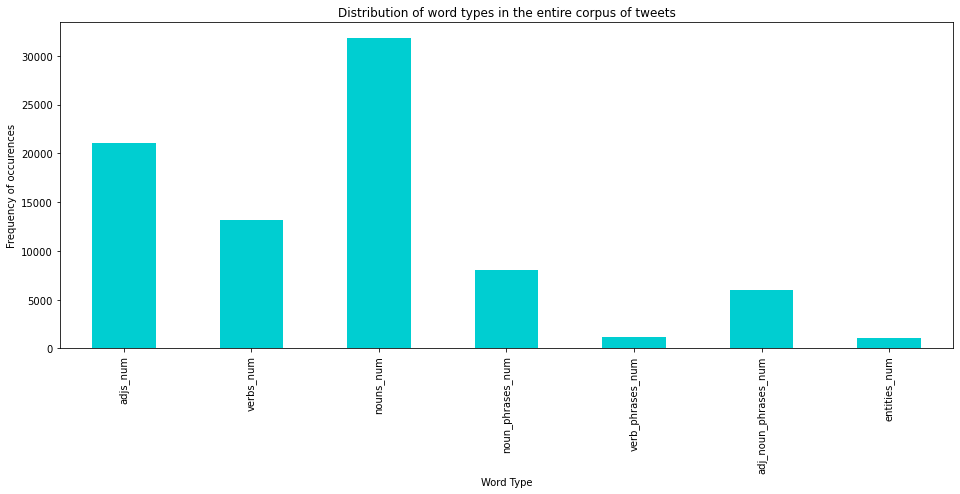

In [230]:
from matplotlib import pyplot as plt
df[df.columns[22:29]].sum().plot.bar(rot=90, color='DarkTurquoise')
# Custom x axis

plt.xlabel("Word Type")
 
plt.ylabel("Frequency of occurences")
plt.title('Distribution of word types in the entire corpus of tweets') 

Do this same analysis but for each group of tweets, so we sum up the number of word types by the groups.

In [231]:
#get dataframe to sum over
import numpy as np
df1 = df[df.columns[np.concatenate([range(2,3),range(22,29)])]]



In [232]:
df2 = df1.groupby('annontation', as_index=False).sum()

In [233]:
df2

,annontation,adjs_num,verbs_num,nouns_num,noun_phrases_num,verb_phrases_num,adj_noun_phrases_num,entities_num
0,ambiguous or hard to classify,647,380,977,231,32,211,37
1,calling out or correction,7085,4396,9989,2291,408,1930,396
2,commercial activity or promotion,189,103,330,116,4,77,10
3,conspiracy,2791,1727,4526,1238,157,885,141
4,emergency,125,90,190,34,6,28,14
5,fake cure,381,229,706,226,17,155,35
6,fake treatment,107,75,191,45,7,36,10
7,false fact or prevention,1639,911,2465,730,76,548,84
8,false public health response,15,8,28,7,0,6,4
9,irrelevant,600,364,1005,312,39,201,22


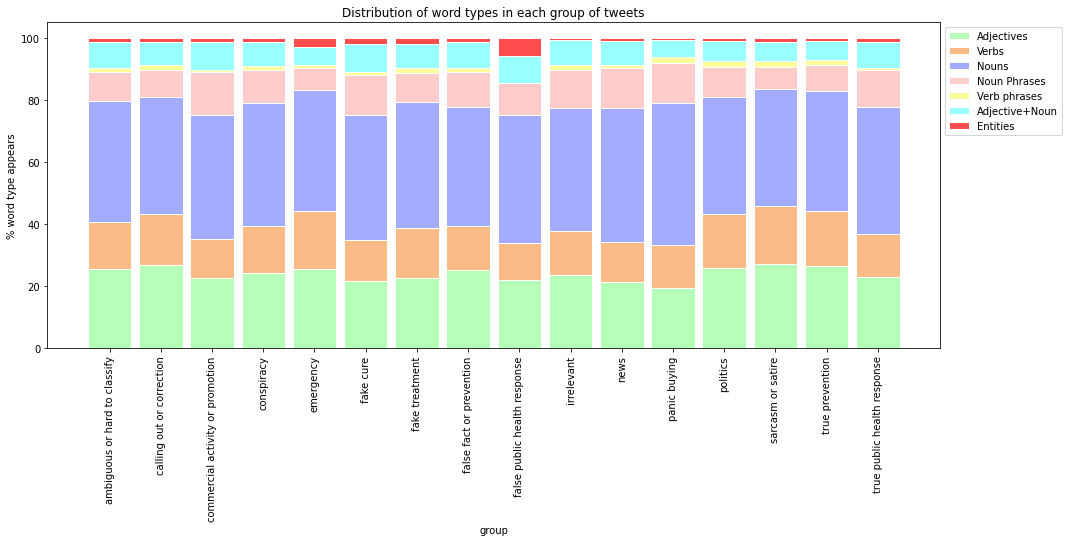

In [234]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
 
# Data
r = list(df2['annontation'])
 
# From raw value to percentage
totals = [i+j+k+l+m+n+o for i,j,k,l,m,n,o in zip(df2['adjs_num'], df2['verbs_num'],
                                         df2['nouns_num'], df2['noun_phrases_num'], df2['verb_phrases_num'], df2['adj_noun_phrases_num'], df2['entities_num'])]

adjs_num = [i / j * 100 for i,j in zip(df2['adjs_num'], totals)]
verbs_num = [i / j * 100 for i,j in zip(df2['verbs_num'], totals)]
nouns_num = [i / j * 100 for i,j in zip(df2['nouns_num'], totals)]
noun_phrases_num = [i / j * 100 for i,j in zip(df2['noun_phrases_num'], totals)]
verb_phrases_num = [i / j * 100 for i,j in zip(df2['verb_phrases_num'], totals)]
adj_noun_phrases_num = [i / j * 100 for i,j in zip(df2['adj_noun_phrases_num'], totals)]
entities_num = [i / j * 100 for i,j in zip(df2['entities_num'], totals)]
 
# plot
barWidth = 0.85
names = tuple(list(df2['annontation']))
# Create green Bars
plt.bar(r, adjs_num, color='#b5ffb9', edgecolor='white', width=barWidth, label="Adjectives")
#Create orange Bars
plt.bar(r, verbs_num, bottom=adjs_num, color='#f9bc86', edgecolor='white', width=barWidth, label="Verbs")
# Create blue Bars
plt.bar(r, nouns_num, bottom=[i+j for i,j in zip(adjs_num, verbs_num)], color='#a3acff', edgecolor='white', width=barWidth, label="Nouns")
plt.bar(r, noun_phrases_num, bottom=[i+j+k for i,j,k in zip(adjs_num, verbs_num, nouns_num)], color='#ffcccc', edgecolor='white', width=barWidth, label="Noun Phrases")
plt.bar(r, verb_phrases_num, bottom=[i+j+k+l for i,j,k,l in zip(adjs_num, verbs_num, nouns_num, noun_phrases_num)], color='#ffff99', edgecolor='white', width=barWidth, label="Verb phrases")
plt.bar(r, adj_noun_phrases_num, bottom=[i+j+k+l+m for i,j,k,l,m in zip(adjs_num, verbs_num, nouns_num, noun_phrases_num,verb_phrases_num)], color='#99ffff', edgecolor='white', width=barWidth, label="Adjective+Noun")
plt.bar(r, entities_num, bottom=[i+j+k+l+m+n for i,j,k,l,m,n in zip(adjs_num, verbs_num, nouns_num, noun_phrases_num,verb_phrases_num,adj_noun_phrases_num)], color='#ff4d4d', edgecolor='white', width=barWidth, label="Entities")

 
# Custom x axis
plt.xticks(r, names, rotation=90)
plt.xlabel("group")
 
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

plt.ylabel("% word type appears")
plt.title('Distribution of word types in each group of tweets') 
# Show graphic
plt.rcParams["figure.figsize"] = (16,6)
plt.show()

### 2. Similarities

First we take all the text for each group and put it into one row.

In [235]:
dfg = df.groupby("annontation")
# for x , y in dfg:
#      print(x)
#      print(y)

    
    

In [236]:
column_names= ["Annontation", "Text"]
df_groups = pd.DataFrame(columns = column_names)   
annots = []
fulltexts = []

for x, y in dfg:
    #print(x)
    #print(y['text'].str.cat(sep=', '))
    annots.append(x)
    fulltexts.append(y['text'].str.cat(sep=', '))

In [237]:
dfg2 = pd.DataFrame({"Annontation": annots, "Text": fulltexts})

In [238]:
dfg2

,Annontation,Text
0,ambiguous or hard to classify,are hand dryers effective in killing the new c...
1,calling out or correction,"no, lime juice won't immunize you: some people..."
2,commercial activity or promotion,visit https://t.co/gqrtz87i0w for new jersey #...
3,conspiracy,do you think the coronavirus is a natural occu...
4,emergency,bfhp is in need of essential supplies due to c...
5,fake cure,“anti-vaxxers have the cure to the coronavirus...
6,fake treatment,i currently have the flu (haven't been tested ...
7,false fact or prevention,if you went to dr. ricciardi in east orange as...
8,false public health response,italy allows malaria and hiv drugs for coronav...
9,irrelevant,"pags parody! plus, joe talks coronavirus and h..."


Then we convert the text into a matrix where each word is a column and it gets a value 1 if it appears in the group.

In [239]:
dt2 = CountVectorizer().fit_transform(dfg2['Text'])

We use cosine similarity to produce a correlation matrix

In [240]:
from sklearn.metrics.pairwise import cosine_similarity
simi = pd.DataFrame(cosine_similarity(dt2,dt2))

In [241]:
simi

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.951407,0.710882,0.928218,0.762031,0.781331,0.755302,0.888132,0.374929,0.894340,0.764297,0.821555,0.894777,0.935070,0.845954,0.819947
1,0.951407,1.000000,0.768467,0.929981,0.811118,0.807141,0.771616,0.914836,0.447666,0.898867,0.809751,0.855873,0.918822,0.953431,0.885512,0.867512
2,0.710882,0.768467,1.000000,0.719620,0.725741,0.647337,0.653725,0.824105,0.573720,0.742712,0.811023,0.781266,0.739685,0.717877,0.832002,0.838570
3,0.928218,0.929981,0.719620,1.000000,0.757918,0.796624,0.731955,0.858089,0.415083,0.893473,0.834459,0.854849,0.901658,0.914212,0.817155,0.874116
4,0.762031,0.811118,0.725741,0.757918,1.000000,0.678575,0.672576,0.814522,0.436440,0.734060,0.733205,0.733672,0.778550,0.789106,0.819130,0.813748
5,0.781331,0.807141,0.647337,0.796624,0.678575,1.000000,0.785798,0.747627,0.487822,0.735319,0.722016,0.716538,0.788127,0.786461,0.689336,0.787059
6,0.755302,0.771616,0.653725,0.731955,0.672576,0.785798,1.000000,0.744831,0.435436,0.693030,0.693619,0.682270,0.737589,0.725426,0.684972,0.741265
7,0.888132,0.914836,0.824105,0.858089,0.814522,0.747627,0.744831,1.000000,0.463483,0.864897,0.804748,0.837533,0.854271,0.890421,0.905747,0.871630
8,0.374929,0.447666,0.573720,0.415083,0.436440,0.487822,0.435436,0.463483,1.000000,0.373890,0.574430,0.450327,0.408884,0.376851,0.442588,0.549838
9,0.894340,0.898867,0.742712,0.893473,0.734060,0.735319,0.693030,0.864897,0.373890,1.000000,0.813790,0.897840,0.878635,0.913416,0.832903,0.858732


We display this in a heat map, with lighter colours representing a higher similarity. For example, 13 and 1 have a value of 0.95. These groups of tweets are very similar. What groups are they?


In [242]:
annots[1], annots[13] 

('calling out or correction', 'sarcasm or satire')

So calling out/correction and sarcasm tweets are similar.

<AxesSubplot:>

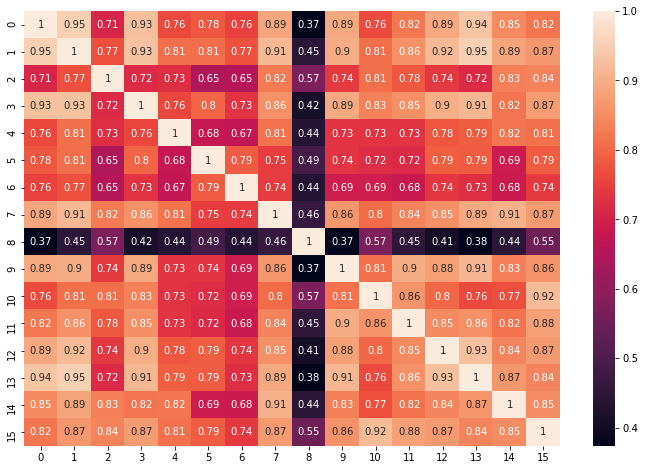

In [243]:
plt.figure(figsize=(12, 8))
sns.heatmap(simi, annot=True)

#### 3. Distribution of word types in entire distribution.

We sum up the number of each word type and display as a percentage of the entire dataset

In [244]:
dfb3 = df1.sum()
dfb3

annontation             irrelevantirrelevantirrelevantirrelevantpoliti...
adjs_num                                                            21030
verbs_num                                                           13184
nouns_num                                                           31841
noun_phrases_num                                                     8004
verb_phrases_num                                                     1207
adj_noun_phrases_num                                                 6010
entities_num                                                         1104
dtype: object

In [245]:
dfb3[1:8]

adjs_num                21030
verbs_num               13184
nouns_num               31841
noun_phrases_num         8004
verb_phrases_num         1207
adj_noun_phrases_num     6010
entities_num             1104
dtype: object

<AxesSubplot:>

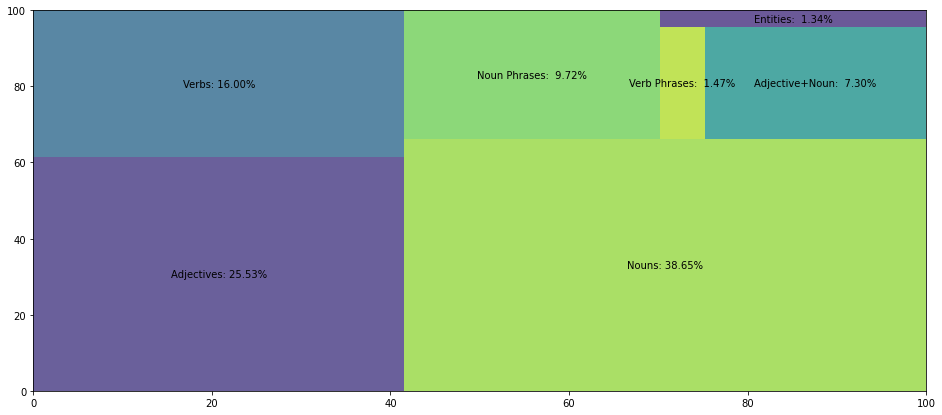

In [246]:

#!pip install squarify
import squarify
label= ["Adjectives", "Verbs", "Nouns", "Noun Phrases", "Verb Phrases", "Adjective+Noun", "Entities"]

perc = [f'{i/dfb3[1:8].sum()*100:5.2f}%' for i in dfb3[1:8]]
lbl = [f'{el[0]}: {el[1]}' for el in zip(label, perc)]
plt.figure(figsize=(16, 7))
squarify.plot(sizes=dfb3[1:8], label=lbl, alpha=.8 )
#squarify.plot(sizes=dfb3[1:6], label =["Adjectives", "Verbs", "Nouns", "Noun Phrases", "Verb Phrases", "Adjective+Noun"], alpha=.8 )
#plt.axis('off')
#plt.show()

#### 4. Which annotated category has the highest number of user mentions?

We count the number of mentions per tweet then aggregate up for each group of tweets to see which has the most mentions

In [247]:
df['numuser'] = df.text.str.count("@user")

In [248]:
dfb4 = df[df.columns[np.concatenate([range(2,3),range(29,30)])]]

In [249]:
dfb4a = dfb4.groupby('annontation', as_index=False).sum()
dfb4a

,annontation,numuser
0,ambiguous or hard to classify,38
1,calling out or correction,381
2,commercial activity or promotion,6
3,conspiracy,166
4,emergency,8
5,fake cure,71
6,fake treatment,22
7,false fact or prevention,51
8,false public health response,0
9,irrelevant,22


In [250]:
totals = dfb4.groupby('annontation', as_index=False).agg('count')
dfb4a['percent'] = (dfb4a['numuser']/totals['numuser'])*100

From the table below, fake treatment has the most mentions per tweet with ~105%.

In [251]:
dfb4a # one entry can have more than mention, hence fake treatment has more mentions than individual tweets so it's >100%

,annontation,numuser,percent
0,ambiguous or hard to classify,38,33.628319
1,calling out or correction,381,31.936295
2,commercial activity or promotion,6,20.689655
3,conspiracy,166,32.549020
4,emergency,8,50.000000
5,fake cure,71,77.173913
6,fake treatment,22,104.761905
7,false fact or prevention,51,20.158103
8,false public health response,0,0.000000
9,irrelevant,22,20.183486


#### 5. Which annotated category uses the most hashtags in a tweet on average?

In [252]:
df['hash_count'] = df['hashtags_orig'].str.len()

In [253]:
dfb5 = df[df.columns[np.concatenate([range(2,3),range(30,31)])]]
dfb5
dfb5a = dfb5.groupby('annontation', as_index=False).sum()
totals = dfb5.groupby('annontation', as_index=False).agg('count')
dfb5a['totals'] = totals['hash_count']
dfb5a['percent'] = (dfb5a['hash_count']/totals['hash_count'])*100


Commercial activity has the most hash tags per tweet at ~241% (that's 2.4 hashtags per tweet)

In [254]:
dfb5a

,annontation,hash_count,totals,percent
0,ambiguous or hard to classify,116,113,102.654867
1,calling out or correction,1017,1193,85.247276
2,commercial activity or promotion,70,29,241.379310
3,conspiracy,739,510,144.901961
4,emergency,16,16,100.000000
5,fake cure,109,92,118.478261
6,fake treatment,16,21,76.190476
7,false fact or prevention,365,253,144.268775
8,false public health response,0,3,0.000000
9,irrelevant,184,109,168.807339


#### 6. What are the top 3 hashtags for each category, including and excluding the hashtags used to filter the tweets?

Create a program that counts the frequency of word appearance. 

In [255]:
from collections import Counter
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [256]:
hash_freq_tab =count_words(df, 'hashtags_orig').head(3)
#count_words(df, 'noun_p').head(10).plot(kind='barh').invert_yaxis()

Top 3 hashtags per category including all tweets

In [257]:
for x in dfb5a['annontation']:
    print(x)
    print(count_words(df.loc[df['annontation'] == x], 'hashtags_orig').head(3))
    print('\n')

ambiguous or hard to classify
             freq
token            
covid19        17
coronavirus    14
bioweapon       4


calling out or correction
                  freq
token                 
coronavirus        179
covid19            167
coronavirusfacts    23


commercial activity or promotion
             freq
token            
covid19         9
coronavirus     8
covidscams      2


conspiracy
             freq
token            
coronavirus   111
covid19        63
bioweapon      62


emergency
                         freq
token                        
coronavirus                 4
covid19                     2
donateplasmarescuealife     2


fake cure
             freq
token            
coronil         8
covid19         8
coronavirus     6


fake treatment
                    freq
token                   
hydroxychloroquine     2
coronavirus            2


false fact or prevention
             freq
token            
coronavirus    39
covid19        35
covid_19       18


false pub

Top 3 hashtags per category excluding tweets quoted in the assignment

In [258]:
for x in dfb5a['annontation']:
    print(x)
    print(count_words(df.loc[df['annontation'] == x], 'hashtags_del').head(3))
    print('\n')

ambiguous or hard to classify
           freq
token          
bioweapon     4
billgates     3
covid         3


calling out or correction
                  freq
token                 
coronavirusfacts    23
lie                 23
covidiots           22


commercial activity or promotion
              freq
token             
covidscams       2
disinfectant     2
cleaning         2


conspiracy
           freq
token          
bioweapon    62
china        26
5g           14


emergency
                         freq
token                        
donateplasmarescuealife     2


fake cure
                    freq
token                   
coronil                8
covid                  6
hydroxychloroquine     6


fake treatment
                    freq
token                   
hydroxychloroquine     2


false fact or prevention
                    freq
token                   
covid_19              18
hydroxychloroquine     7
health                 6


false public health response
Empty Data

### Task C -  Affect Analysis 

In [259]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [260]:
dfg2['Text'] ####here is the column we'll do the analysis on 

0     are hand dryers effective in killing the new c...
1     no, lime juice won't immunize you: some people...
2     visit https://t.co/gqrtz87i0w for new jersey #...
3     do you think the coronavirus is a natural occu...
4     bfhp is in need of essential supplies due to c...
5     “anti-vaxxers have the cure to the coronavirus...
6     i currently have the flu (haven't been tested ...
7     if you went to dr. ricciardi in east orange as...
8     italy allows malaria and hiv drugs for coronav...
9     pags parody! plus, joe talks coronavirus and h...
10    health authorities have identified a new coron...
11    as the demand for hand sanitisers soars in the...
12    i hope your father recovers from the virus as ...
13    i protected myself from the coronavirus by wea...
14    wash your hands as often as possible #cureforc...
15    delhi hc restrains publication of certain adve...
Name: Text, dtype: object

This prepares a dataset with the group and all the text within the group. 

In [261]:
column_names= ["Annontation", "Text"]
df_groups = pd.DataFrame(columns = column_names)   
annots = []
fulltexts = []

for x, y in dfg:
    #print(x)
    #print(y['text'].str.cat(sep=', '))
    annots.append(x)
    fulltexts.append(y['text5'].str.cat(sep=', '))

dfg2 = pd.DataFrame({"Annontation": annots, "Text": fulltexts})

We now use the vader dictionary on the text. This matches up words in the dictionary with the words in the tweets and gives it a score based on those words. For example, if the text contains the word "good" then it will receive +1, if it contains the word "bad" it will receive -1 points. If it contains "very bad" it will get -2, for example. Depending on how positive/negative the word/phrase it, it gets more/less points. From this we can give each body of a text a score for positive or negative to see if each groups' tweets are positive or negative.

In [262]:
dfg2['scores'] = dfg2['Text'].apply(lambda review: sid.polarity_scores(review))
dfg2

,Annontation,Text,scores
0,ambiguous or hard to classify,are hand dryers effective in killing the new c...,"{'neg': 0.129, 'neu': 0.754, 'pos': 0.117, 'co..."
1,calling out or correction,"no, lime juice won't immunize you: some people...","{'neg': 0.178, 'neu': 0.719, 'pos': 0.103, 'co..."
2,commercial activity or promotion,visit https://t.co/gqrtz87i0w for new jersey #...,"{'neg': 0.068, 'neu': 0.799, 'pos': 0.133, 'co..."
3,conspiracy,do you think the coronavirus is a natural occu...,"{'neg': 0.14, 'neu': 0.766, 'pos': 0.094, 'com..."
4,emergency,bfhp is in need of essential supplies due to c...,"{'neg': 0.084, 'neu': 0.79, 'pos': 0.126, 'com..."
5,fake cure,“anti-vaxxers have the cure to the coronavirus...,"{'neg': 0.075, 'neu': 0.836, 'pos': 0.09, 'com..."
6,fake treatment,i currently have the flu (haven't been tested ...,"{'neg': 0.025, 'neu': 0.808, 'pos': 0.167, 'co..."
7,false fact or prevention,if you went to dr. ricciardi in east orange as...,"{'neg': 0.087, 'neu': 0.716, 'pos': 0.197, 'co..."
8,false public health response,italy allows malaria and hiv drugs for coronav...,"{'neg': 0.0, 'neu': 0.947, 'pos': 0.053, 'comp..."
9,irrelevant,"pags parody! plus, joe talks coronavirus and h...","{'neg': 0.108, 'neu': 0.781, 'pos': 0.112, 'co..."


Can see from this table if a category is negative or positive. Positive are any scored >0, negative are any scored <0. "comp_score" column tells us if the category is positive or negative.

In [263]:
dfg2['compound']  = dfg2['scores'].apply(lambda score_dict: score_dict['compound'])
dfg2['comp_score'] = dfg2['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
dfg2


,Annontation,Text,scores,compound,comp_score
0,ambiguous or hard to classify,are hand dryers effective in killing the new c...,"{'neg': 0.129, 'neu': 0.754, 'pos': 0.117, 'co...",-0.9973,neg
1,calling out or correction,"no, lime juice won't immunize you: some people...","{'neg': 0.178, 'neu': 0.719, 'pos': 0.103, 'co...",-1.0000,neg
2,commercial activity or promotion,visit https://t.co/gqrtz87i0w for new jersey #...,"{'neg': 0.068, 'neu': 0.799, 'pos': 0.133, 'co...",0.9941,pos
3,conspiracy,do you think the coronavirus is a natural occu...,"{'neg': 0.14, 'neu': 0.766, 'pos': 0.094, 'com...",-1.0000,neg
4,emergency,bfhp is in need of essential supplies due to c...,"{'neg': 0.084, 'neu': 0.79, 'pos': 0.126, 'com...",0.9764,pos
5,fake cure,“anti-vaxxers have the cure to the coronavirus...,"{'neg': 0.075, 'neu': 0.836, 'pos': 0.09, 'com...",0.9915,pos
6,fake treatment,i currently have the flu (haven't been tested ...,"{'neg': 0.025, 'neu': 0.808, 'pos': 0.167, 'co...",0.9981,pos
7,false fact or prevention,if you went to dr. ricciardi in east orange as...,"{'neg': 0.087, 'neu': 0.716, 'pos': 0.197, 'co...",1.0000,pos
8,false public health response,italy allows malaria and hiv drugs for coronav...,"{'neg': 0.0, 'neu': 0.947, 'pos': 0.053, 'comp...",0.4404,pos
9,irrelevant,"pags parody! plus, joe talks coronavirus and h...","{'neg': 0.108, 'neu': 0.781, 'pos': 0.112, 'co...",-0.7671,neg


We plot this on a bar chart

<AxesSubplot:xlabel='Annontation'>

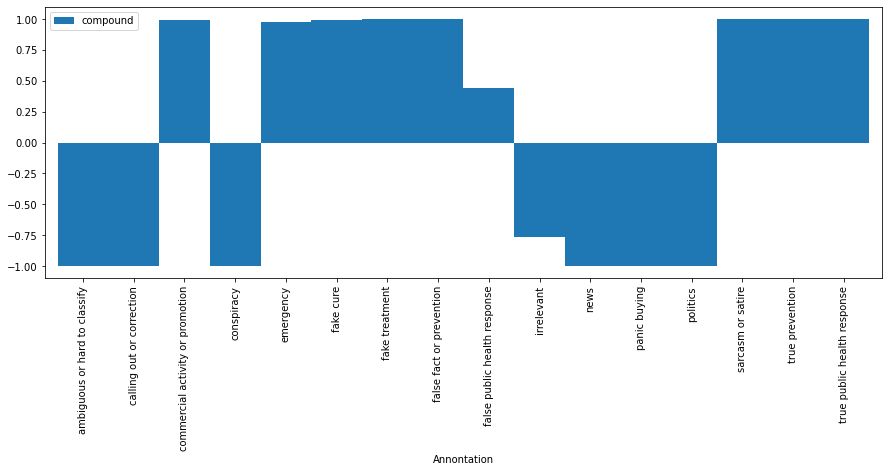

In [264]:
# Custom x axis
dfg2.plot.bar(figsize=(15,5),width=1, x='Annontation')

### Task D. Text Classification

We want to create a binary classifier of "misinformation" and "no misinformation". First we combined tweets. We exclude "sarcasm" and "irrelevant" from this analysis. Sarcasm could confuse the classifier as the classifier probably won't be able to pick up on a sarcastic tone. Irrelevant is excluded because it's not relevant.

In [265]:
## merge tweets 
df

misinfo = ["conspiracy", "fake cure", "fake treatment", "false fact or prevention"]
no_misinfo = ["true treatment", "true prevention", "true public health response", "calling out or correction", "emergency", "news", 
             "irrelevant", "commercial activity or promotion", "panic buying", "politics"]


Assign each tweet a misinfo or no misinfo label

In [266]:
# create a list of our conditions
conditions = [
    (df["annontation"].isin(misinfo)),
    (df["annontation"].isin(no_misinfo)),
    (~df["annontation"].isin(misinfo)) & (~df["annontation"].isin(no_misinfo))
    ]

# create a list of the values we want to assign for each condition
values = ['misinfo', 'no_misinfo', 'n/a']

# create a new column and use np.select to assign values to it using our lists as arguments
df['class1'] = np.select(conditions, values)

In [267]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df[['annontation', 'class1']].head())

  annontation      class1
0  irrelevant  no_misinfo
1  irrelevant  no_misinfo
2  irrelevant  no_misinfo
3  irrelevant  no_misinfo
4    politics  no_misinfo


Drop the tweets we don't deem relevant to the analysis. 

In [268]:
#drop n/a
dfd1 = df[df.class1 != 'n/a']

The column 'text9' is after our pre-processing steps. We change it to a list to a string so it can be used in the classifier.

In [269]:
#hello = ' '.join(dfd1['text9'])
#dfd1['text9']
dfd1['text10'] = [' ' .join(x) for x in dfd1['text9']]

<ipython-input-269-59c8dd610ef5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfd1['text10'] = [' ' .join(x) for x in dfd1['text9']]


Split the data into train and test. Train data is used to create the model. We then use the test data to see if the model is accurate on data we didn't use in the model to see if it can make predictions on new data.

In [270]:
#use text6
X_train, X_test, Y_train, Y_test = train_test_split(dfd1['text10'],
                                                    dfd1['class1'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=dfd1['class1']
                                                   )

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  2503
Size of Test Data  626


Transform the test data into a matrix of numbers, where each word gets a number of how frequently it appears in each class of info and misinfo. The grid search below, which tells us the best parameters to use for this model, tells us that an ngram range of 1,3 is the best. That means we include phrases of 1, 2 and 3 words long in the analysis. For example for a 3 gram phrase, "coronavirus is bad" would be included. For a 2 gram phrase "go away" would be included.

In [271]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,3), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

We use a Support Vector Machine to classify as this is better with text data as it's sparse data (the matrix has a lot of 0s in, hence it is sparse).

In [272]:
#from sklearn.svm.LinearSVC import LinearSVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

In [273]:
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

LinearSVC(max_iter=10000, random_state=0, tol=1e-05)

We test the model on our test data to see how accurate it is. For each tweet we let the model predict if it's information or misinformation and we compare it to the actual label. What percentage of the time is it correct, the accuracy score tells us that, 82.4%

In [274]:
X_test_tf = tfidf.transform(X_test)

Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8242811501597445


This is a confusion matrix which tells us how well the model performs.

For the test data, and for the misinformation tweets, the model gets it right 104 times, but gets it wrong 71 times. That's not so good.

For the no_information, it gets it wrong 39 times but gets it right 412 times. That's good. So it's good at detecting tweets with no_misinformation but not as good det picking up tweets with misinformation.

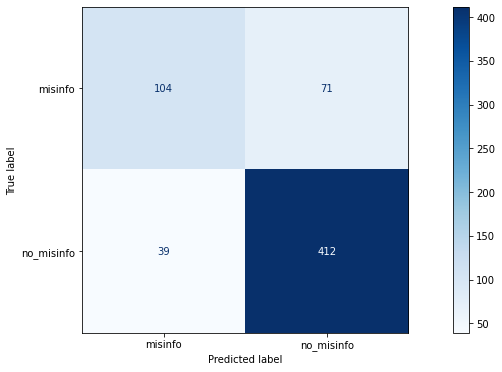

In [275]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model1,X_test_tf,
                      Y_test, values_format='d',
                      cmap=plt.cm.Blues)
plt.show()

Here are some examples where the model gets it right

In [276]:
# Create a DataFrame combining the Title and Description,
# Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred }
result = pd.DataFrame(frame)


result[((result['actual'] == 'no_misinfo') | (result['actual'] == 'misinfo')) &(result['actual'] == result['predicted'])].sample(4)

,text,actual,predicted
1267,wash hand properly 20 sec prior wash fruit luk...,no_misinfo,no_misinfo
2435,aunt friend tell coronavirus fake create democ...,no_misinfo,no_misinfo
741,@user talk malaria drug miracle cure covid19,no_misinfo,no_misinfo
200,@user flu shot increase risk respiratory virus...,misinfo,misinfo


Here are some examples where the model gets it wrong.

In [277]:
result[((result['actual'] == 'misinfo')) &(result['actual'] != result['predicted'])].sample(4)


,text,actual,predicted
3069,church phony covid-19 cure sell north texas gr...,misinfo,no_misinfo
3589,cure covid-19 popolo plant try manomano ka ike...,misinfo,no_misinfo
556,@user @user simple trick kill coronavirus hair...,misinfo,no_misinfo
3588,expect cure covid god know come lockdown weapo...,misinfo,no_misinfo


In [278]:
dfd1['text'][85]

"chinese wet market a farmer's market on steroids, spread all sorts of viruses, world now condemns!  chlorinated chicken safer than the fresh chicken that caused coronavirus says dominic lawson https://t.co/lkzgf0bmbj…  #borisjohnson  @user #backboris #johnson #boris https://t.co/mkazelksvc"

This is a grid search which tells us the best parameters to use.

In [279]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words="english")),
            ('model', LinearSVC(random_state=42, tol=1e-5))])

grid_param = [{
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__penalty': ['l2'],
    'model__loss': ['hinge'],
    'model__max_iter': [10000]
}, {
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__C': [1, 10],
    'model__tol': [1e-2, 1e-3]
}]

gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)
gridSearchProcessor.fit(dfd1['text10'], dfd1['class1'])

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

Best alpha parameter identified by grid search  {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 3)}
Best result identified by grid search  0.8117648562300319
